In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline  
    # 주피터 노트북을 실행한 브라우저에서 바로 그림을 볼 수 있게 해줌. 안해도 요즘은 나온다
%config InlineBackend.figure_format='retina'  
    # 그래프를 더 높은 해상도로 그려줌
#한글설정
plt.rc('font', family='Malgun Gothic') # 윈도우즈
#plt.rc('font', family='AppleGothic') # mac
plt.rc('axes', unicode_minus=False)  # 축의 - 깨짐 방지
# 경고 메세지 안보이게
import warnings
warnings.filterwarnings(action='ignore')

# 배 분석

In [ ]:
# 데이터 로딩 1
df = pd.read_csv('datasets/EDA용데이터_스케일링O_인코딩X/배(EDA용)_스케일링만.csv', encoding='cp949')

In [29]:
# 데이터 로딩 2 - 스케일 안한것
df = pd.read_csv('datasets/작물_lag만_추가_스케일링X_인코딩X/배추_lag처리.csv', encoding='cp949')

In [5]:
df['holiday_score'].sum()

326357.4006

In [30]:
# 상관관계 분석을 위해 연도+주차로 데이터 형 변경 후 년도 및 일자 제외
df['weekno'] = (df['year'].astype(str) + df['week'].astype(str).str.zfill(2)).astype(int)
df.drop(columns=['week', 'week_start'], inplace=True)

In [7]:
# 작기정보가 비어있거나 0으로만 차있는 경우 확인됨 (데이터 확인할 것) - 작기 데이터에 없는 작물이 있음
df['grow_score'].sum()

20078118.0

In [31]:
# 아이템 코드(품목코드) 삽입 - 매핑용
item_nm = '배추'
df['item_code'] = 1001 # 배추

In [ ]:
## 작기 정보가 비어있으면 실행
# 데이터 로드
df_grow = pd.read_csv('datasets/factor_external_weekly_ver_0721.csv', encoding='utf-8')

### 아이템 코드
# 양파 : 1201, 배추 : 1001, 상추 : 1005, 사과 : 0601, 무 : 1101, 감자 : 0501, 대파 : 1202
# 마늘 : 1209, 딸기 : 0804, 방울토마토 : 0806, 오이 : 0901, 양배추 : 1004, 고구마 : 0502, 배 : 0602 ,건고추 : 1207

# 기 생성된 휴일여부	명절지수	작기정보 칼럼 삭제
df.drop(columns=['holiday_flag', 'holiday_score', 'grow_score'], inplace=True)
# 병합하기
merged_df  = pd.merge( df,
                    df_grow,
                    left_on=['weekno', 'item_code'],
                    right_on=['weekno', 'item_code'],  
                    how='left'
                )
df = merged_df.drop_duplicates()
df.info()
df.head()

In [171]:
df.to_csv('datasets/작물_lag만_추가_스케일링X_인코딩X/배_lag처리_2.csv', index=False, encoding='cp949')

In [10]:
# 독립변수 선별 1 그룹집계
# 작기, 명절지표, 거래량, 품종

df1 = df[['weekno', '품종코드', 'holiday_flag', 'holiday_score','grow_score', '총거래량(kg)', '평균단가(원)']]
df_group1 = df1.groupby(['weekno', '품종코드', 'holiday_flag', 'holiday_score', 'grow_score']).agg({
    '총거래량(kg)':'sum', 
    '평균단가(원)':'mean'
}).reset_index()
df_group1

,weekno,품종코드,holiday_flag,holiday_score,grow_score,총거래량(kg),평균단가(원)
0,201805,1,2,0.2143,22.0,5238.0,948.400000
1,201805,1,4,0.4286,44.0,4624.0,1021.333333
2,201805,1,6,0.6429,66.0,5469.0,1827.500000
3,201805,1,8,0.8572,88.0,14200.0,847.000000
4,201805,1,10,1.0715,110.0,53908.0,896.333333
...,...,...,...,...,...,...,...
31064,202522,100,14,0.0000,0.0,6650.0,403.500000
31065,202522,100,16,0.0000,0.0,24232.0,294.000000
31066,202522,100,18,0.0000,0.0,21600.0,308.000000
31067,202522,100,20,0.0000,0.0,72.0,2983.000000


In [12]:
df_group1['품종코드'].value_counts()

품종코드
8      9045
99     7626
100    5863
4      4703
1      3832
Name: count, dtype: int64

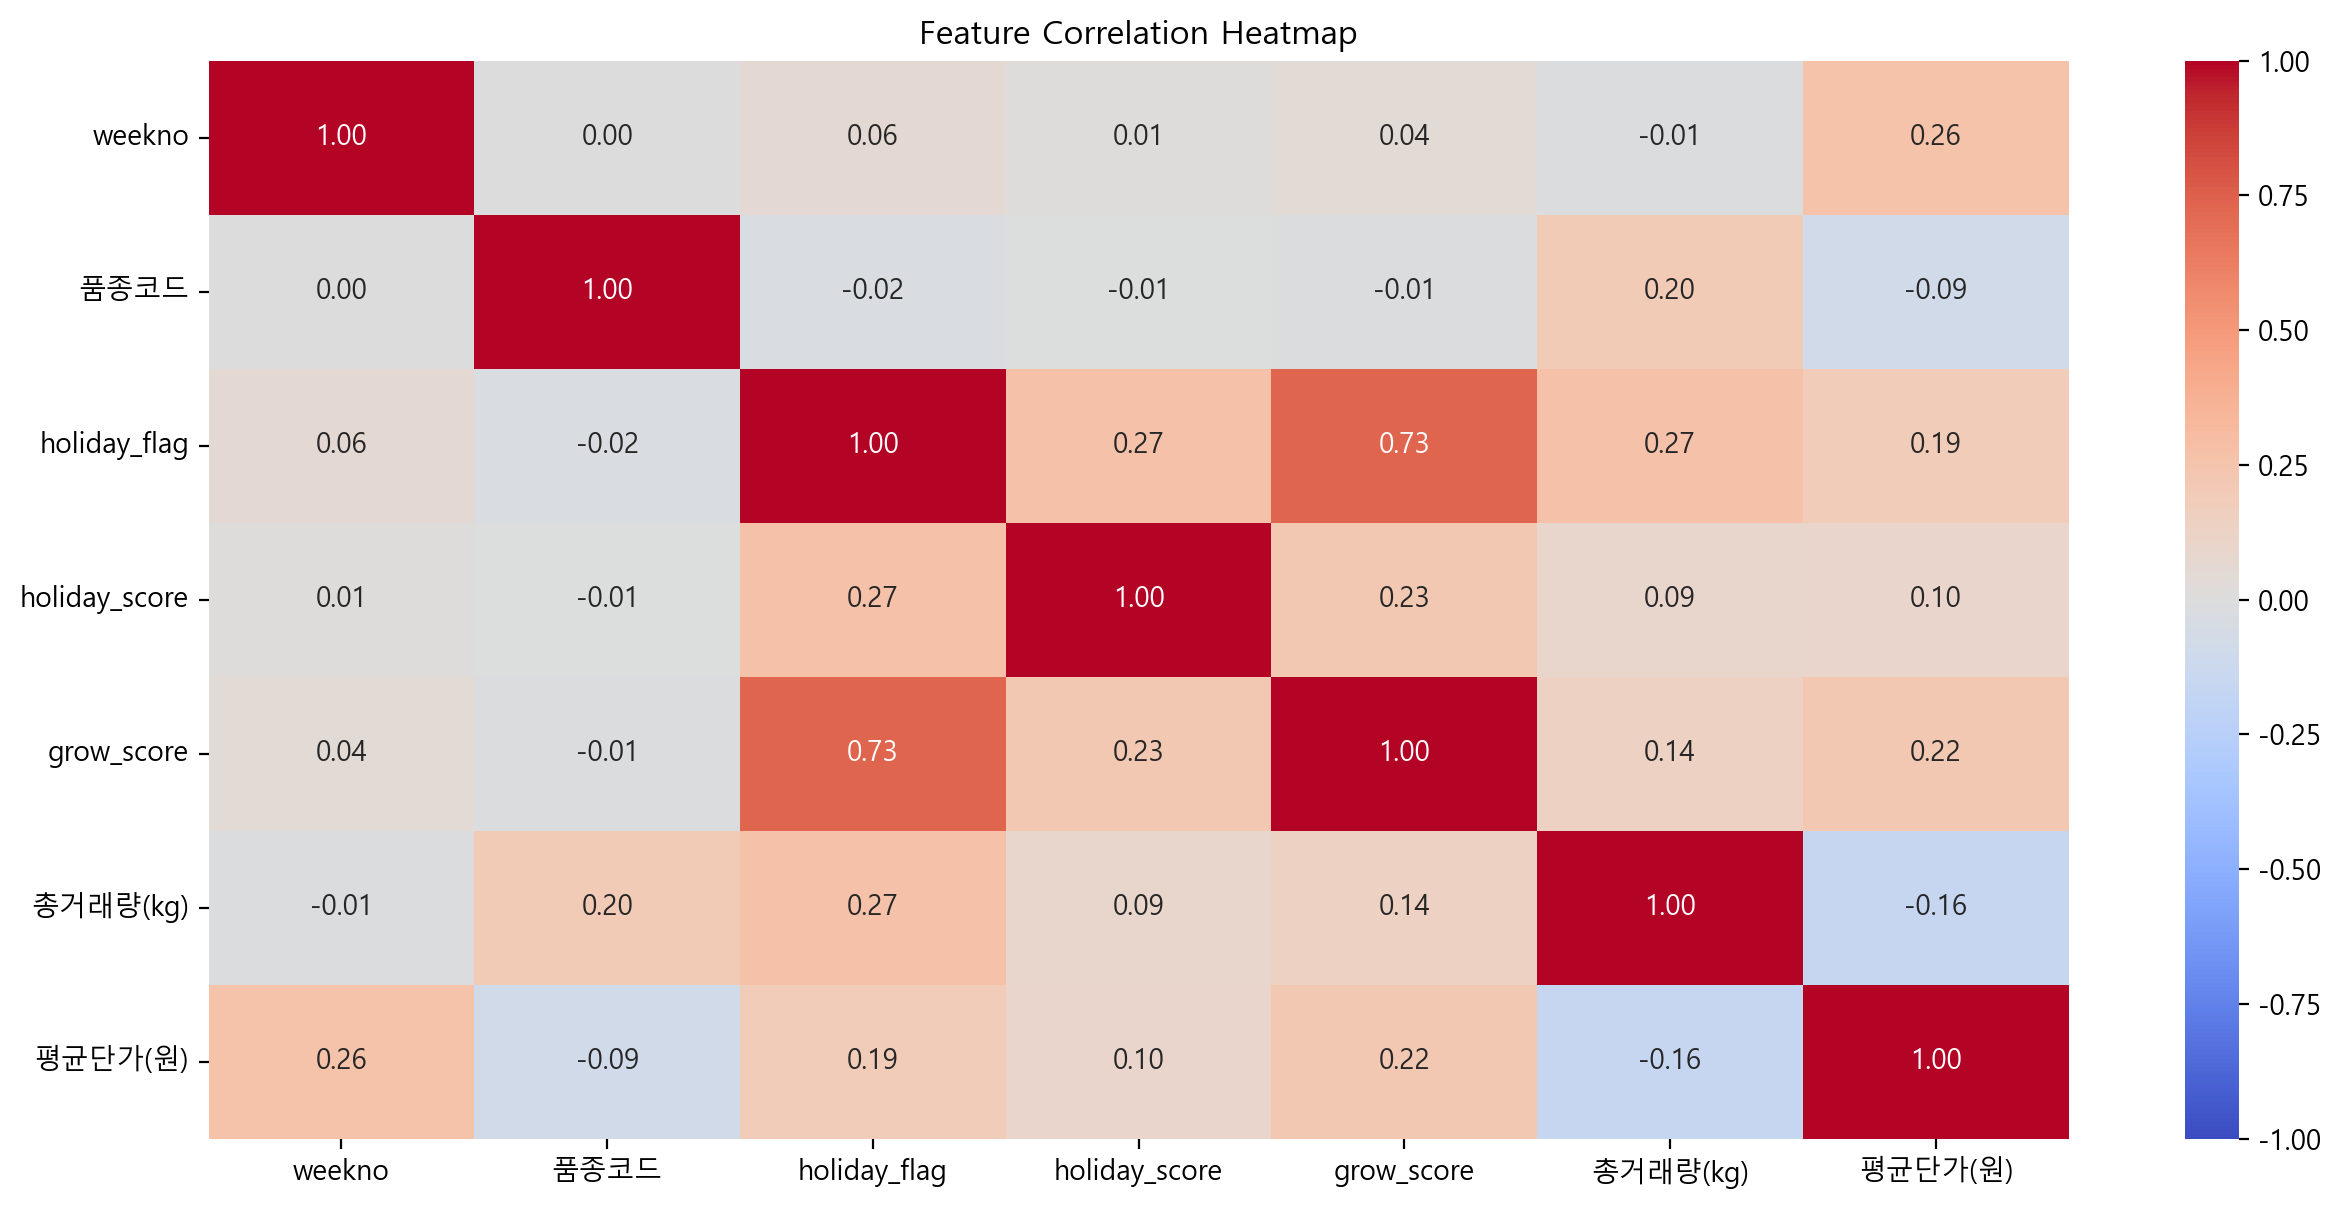

In [13]:
# 상관계수 행렬 계산
corr_matrix = df_group1.corr()

# 히트맵 그리기
plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()
## 주차에 따른 약간 상관관계가 있으며

In [16]:
# 독립변수 선별 2 그룹집계
# 작기, 명절지표, 거래량

df2 = df[['weekno', 'holiday_flag', 'holiday_score','grow_score', '총거래량(kg)', '평균단가(원)']]
df_group2 = df2.groupby(['weekno', 'holiday_flag', 'holiday_score', 'grow_score']).agg({
    '총거래량(kg)':'sum', 
    '평균단가(원)':'mean'
}).reset_index()
df_group2

,weekno,holiday_flag,holiday_score,grow_score,총거래량(kg),평균단가(원)
0,201805,2,0.2143,22.0,85879.4,1042.000000
1,201805,4,0.4286,44.0,100525.0,987.968750
2,201805,6,0.6429,66.0,82669.2,1152.848485
3,201805,8,0.8572,88.0,155636.0,1066.206897
4,201805,10,1.0715,110.0,67433.0,1265.230769
...,...,...,...,...,...,...
13442,202522,94,0.0000,0.0,758701.4,450.000000
13443,202522,126,0.0000,0.0,1823.5,2799.000000
13444,202522,200,0.0000,0.0,52275.2,618.000000
13445,202522,272,0.0000,0.0,181058.5,1076.000000


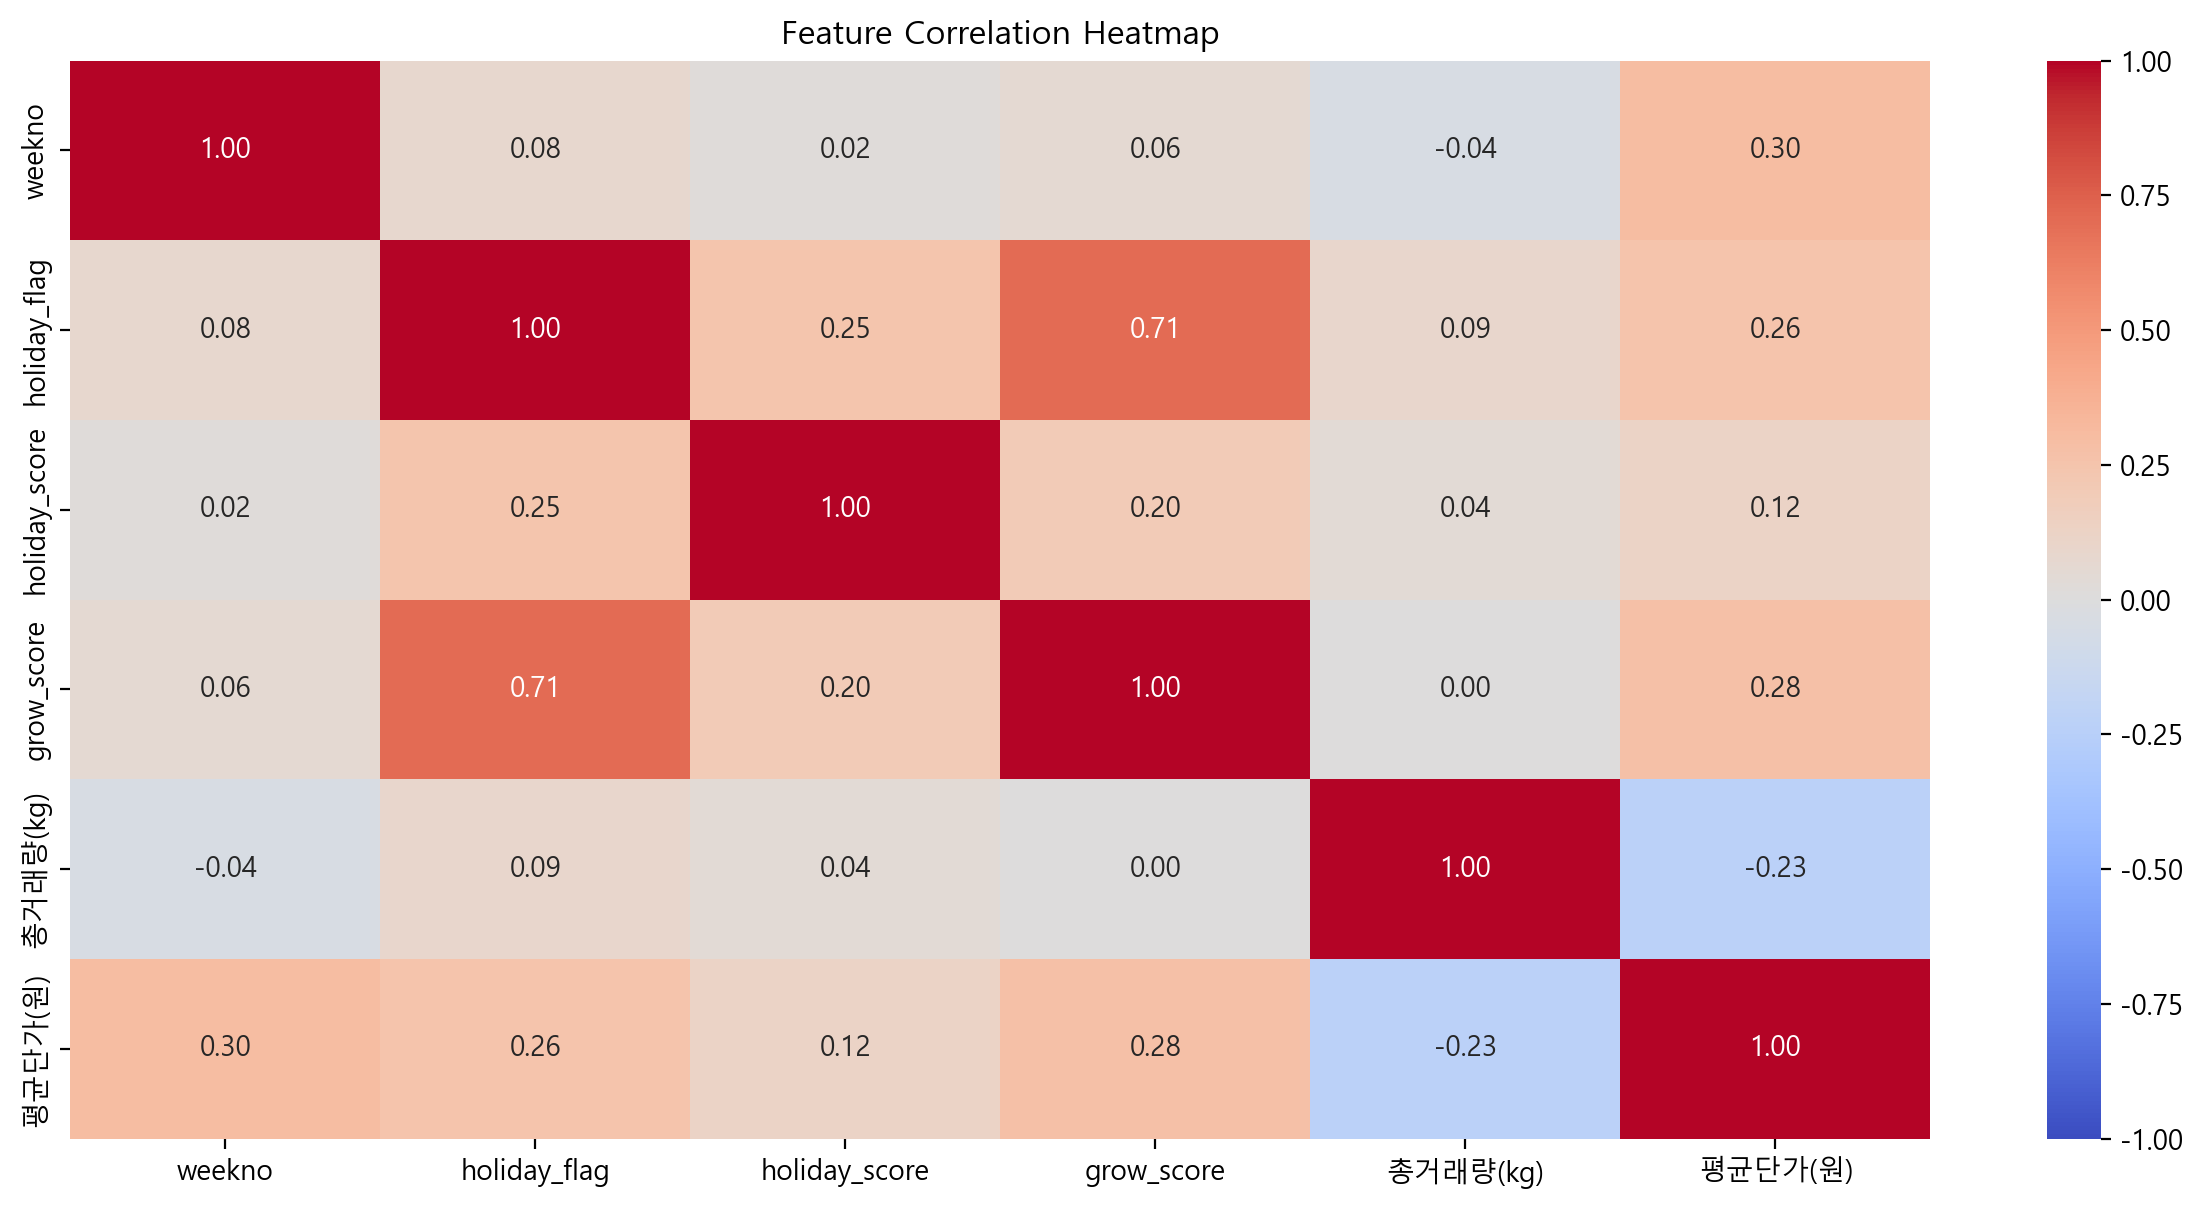

In [17]:
# 상관계수 행렬 계산
corr_matrix = df_group2.corr()

# 히트맵 그리기
plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()
## 주차에 따른 약간 상관관계가 있으며

In [21]:
df = df_group2.copy()

from scipy.stats import pearsonr
# 예시: x, y 두 변수 간 상관계수와 p-value 계산
# p-value < 0.05 : “통계적으로 유의미하다”
# p-value ≥ 0.05 : “우연일 수 있다(유의하지 않다)”


corr, p_value = pearsonr(df['평균단가(원)'], df['holiday_score'])
print(f'{item_nm}의 평균단가 - 명절지수')
print(f'상관계수: {corr:.2f}, p-value: {p_value:.4f}')
print()
# 
corr, p_value = pearsonr(df['평균단가(원)'], df['총거래량(kg)'])
print(f'{item_nm}의 평균단가 - 총거래량')
print(f'상관계수: {corr:.2f}, p-value: {p_value:.4f}')
print()
# 
# corr, p_value = pearsonr(df['평균단가(원)'], df['품종코드'])
# print('배의 평균단가 - 품종코드')
# print(f'상관계수: {corr:.2f}, p-value: {p_value:.4f}')
# print()
# 
corr, p_value = pearsonr(df['평균단가(원)'], df['weekno'])
print(f'{item_nm}의 평균단가 - weekno')
print(f'상관계수: {corr:.2f}, p-value: {p_value:.4f}')
print()



배추의 평균단가 - 명절지수
상관계수: 0.12, p-value: 0.0000

배추의 평균단가 - 총거래량
상관계수: -0.23, p-value: 0.0000

배추의 평균단가 - weekno
상관계수: 0.30, p-value: 0.0000



In [148]:
df_scaled

,품종코드,등급코드,직팜산지코드,총거래량(kg),일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),...,최고기온_t-4,최저기온_t-4,평균상대습도_t-4,강수량(mm)_t-4,1시간최고강수량(mm)_t-4,item_code,weekno,holiday_flag,holiday_score,grow_score
0,1,11,1000,0.815441,0.718670,0.742238,0.677519,0.516597,0.000202,0.0,...,0.726354,0.712403,0.486632,0.000000,0.000000,0.0,201805,0.333333,0.038762,0.051948
1,1,11,1008,0.625238,0.722332,0.738628,0.688372,0.538624,0.000000,0.0,...,0.734296,0.667442,0.555199,0.000000,0.000000,0.0,201805,0.333333,0.038762,0.051948
2,1,11,1019,0.718731,0.728749,0.747292,0.676744,0.533264,0.000000,0.0,...,0.742960,0.684496,0.591743,0.000000,0.000000,0.0,201805,0.333333,0.038762,0.051948
3,1,11,1026,0.911570,0.716953,0.741516,0.647287,0.575088,0.000000,0.0,...,0.735740,0.704651,0.621512,0.000000,0.000000,0.0,201805,0.333333,0.038762,0.051948
4,1,11,1027,0.871150,0.715217,0.741516,0.647287,0.579504,0.000000,0.0,...,0.735740,0.704651,0.627403,0.000000,0.000000,0.0,201805,0.333333,0.038762,0.051948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77423,100,13,1085,0.375414,0.915973,0.927798,0.883721,0.555046,0.000000,0.0,...,0.916245,0.822481,0.580734,0.022356,0.034056,0.0,202522,0.333333,0.000000,0.636364
77424,100,12,1159,0.301839,0.900076,0.898195,0.886822,0.647706,0.000000,0.0,...,0.926354,0.834109,0.490826,0.001350,0.001731,0.0,202522,0.333333,0.000000,0.636364
77425,100,13,1159,0.372139,0.900076,0.898195,0.886822,0.647706,0.000000,0.0,...,0.909025,0.851938,0.507339,0.000000,0.000000,0.0,202522,0.333333,0.000000,0.636364
77426,100,11,1001,0.174475,0.896291,0.914801,0.859690,0.587156,0.000000,0.0,...,0.770397,0.737209,0.831193,0.000000,0.000000,0.0,202522,0.333333,0.000000,0.636364


# 명절 및 작기 점수에 따른 가격 변화 패턴 분석 (Box plot, Time series line)

## 스케일 - 그래프용

In [36]:
# 그룹된 테이블 확인하여 아래 셀 수정
df_explain = df[['weekno','일평균기온', '최고기온','최저기온', '평균상대습도', '강수량(mm)', '1시간최고강수량(mm)', 'holiday_score', 'grow_score', '총거래량(kg)', '평균단가(원)']]
df_group3 = df_explain.groupby(['weekno']).agg({
    '일평균기온':'mean', '최고기온':'mean','최저기온':'mean', '평균상대습도':'mean', '강수량(mm)':'mean', '1시간최고강수량(mm)':'mean', 
    'holiday_score':'mean', 'grow_score':'mean', '총거래량(kg)':'mean', '평균단가(원)':'mean'
}).reset_index()
df_group3

,weekno,일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_score,grow_score,총거래량(kg),평균단가(원)
0,201805,-2.854436,3.676078,-8.703137,52.898640,1.448627,0.000000,1.695071,174.015686,17359.667059,1146.117647
1,201806,-2.700794,5.961765,-10.429412,53.612980,1.809804,0.000000,25.696078,239.830065,20512.958497,1315.741830
2,201807,0.013707,8.462021,-6.991289,60.976235,1.134495,0.000000,29.799622,154.926829,13901.062718,1037.013937
3,201808,2.394678,10.339385,-3.718154,53.068036,1.050769,0.000000,6.698462,53.587692,14485.210154,882.240000
4,201809,4.603594,13.308169,-3.283944,60.034757,36.272676,0.000000,0.000000,0.000000,15431.468169,822.290141
...,...,...,...,...,...,...,...,...,...,...,...
378,202518,14.685777,23.656803,6.992857,58.219557,37.197619,17.237075,0.000000,369.333333,17597.296769,1478.540816
379,202519,13.990926,21.185971,7.831295,72.973097,37.201439,10.056475,0.000000,315.906475,20284.974101,1299.888489
380,202520,18.071222,25.263609,9.259327,73.985251,49.808257,15.578287,0.000000,0.000000,18067.760856,1138.498471
381,202521,19.275036,26.957480,12.186352,73.625206,2.999475,1.646719,0.000000,0.000000,14233.487139,821.393701


In [48]:
## 그래프에는 QuantileTransformer를 추천 

# 복사본 생성
df_scaled = df_group3.copy()

# 🎯 로그 변환 + RobustScaler: 총거래량(kg)
df_scaled['총거래량(kg)'] = np.log1p(df_scaled['총거래량(kg)'])

# ❗제외할 컬럼
target = '평균단가(원)'
exclude_cols = ['year', 'week', '품종코드', '등급코드', '직팜산지코드', target]

# 수치형 컬럼 중 제외대상 뺀 컬럼들 추출
numerical_cols = df_group3.select_dtypes(include=["int64", "float64"]).columns.tolist()
scale_cols = [col for col in numerical_cols if col not in exclude_cols]

In [49]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, RobustScaler
# QuantileTransformer  분포를 골고루 변환 0~1 범위
scaler = QuantileTransformer()
df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])
df_scaled

,weekno,일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_score,grow_score,총거래량(kg),평균단가(원)
0,201805,0.020942,0.023560,0.018325,0.049738,0.243455,0.000000,0.874346,0.599476,0.552356,1146.117647
1,201806,0.026178,0.052356,0.007853,0.057592,0.272251,0.000000,0.968586,0.719895,0.798429,1315.741830
2,201807,0.068063,0.123037,0.039267,0.222513,0.222513,0.000000,0.976440,0.560209,0.167539,1037.013937
3,201808,0.151832,0.183246,0.143979,0.054974,0.212042,0.000000,0.897906,0.345550,0.212042,882.240000
4,201809,0.235602,0.259162,0.159686,0.180628,0.782723,0.000000,0.000000,0.000000,0.345550,822.290141
...,...,...,...,...,...,...,...,...,...,...,...
378,202518,0.526178,0.568063,0.507853,0.130890,0.787958,0.835079,0.000000,0.963351,0.578534,1478.540816
379,202519,0.507853,0.471204,0.534031,0.630890,0.790576,0.759162,0.000000,0.884817,0.780105,1299.888489
380,202520,0.641361,0.625654,0.575916,0.662304,0.837696,0.814136,0.000000,0.000000,0.636126,1138.498471
381,202521,0.670157,0.706806,0.651832,0.657068,0.363874,0.539267,0.000000,0.000000,0.191099,821.393701


In [ ]:
# 위셀과 교체용
# Min-max scaler 적용
scaler = MinMaxScaler()
df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])

# RobustScaler 적용
scaler = RobustScaler()
df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])

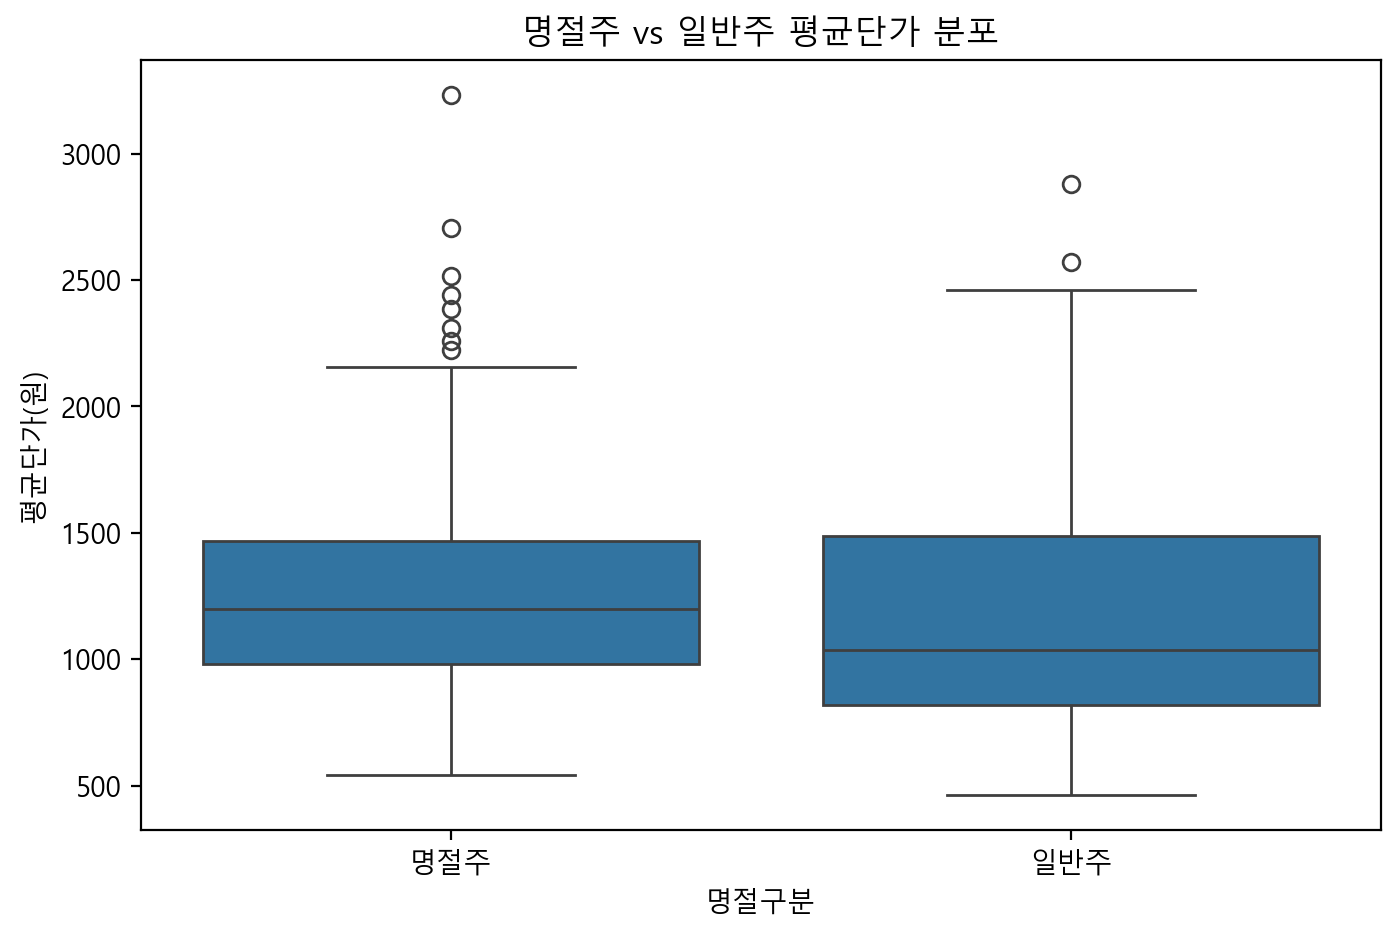

In [50]:
# 명절주 vs 일반주 평균단가 분포
df = df_scaled.copy()
df['명절구분'] = df['holiday_score'].apply(lambda x: '명절주' if x > 0 else '일반주')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='명절구분', y='평균단가(원)', data=df)
plt.title("명절주 vs 일반주 평균단가 분포")
plt.show()

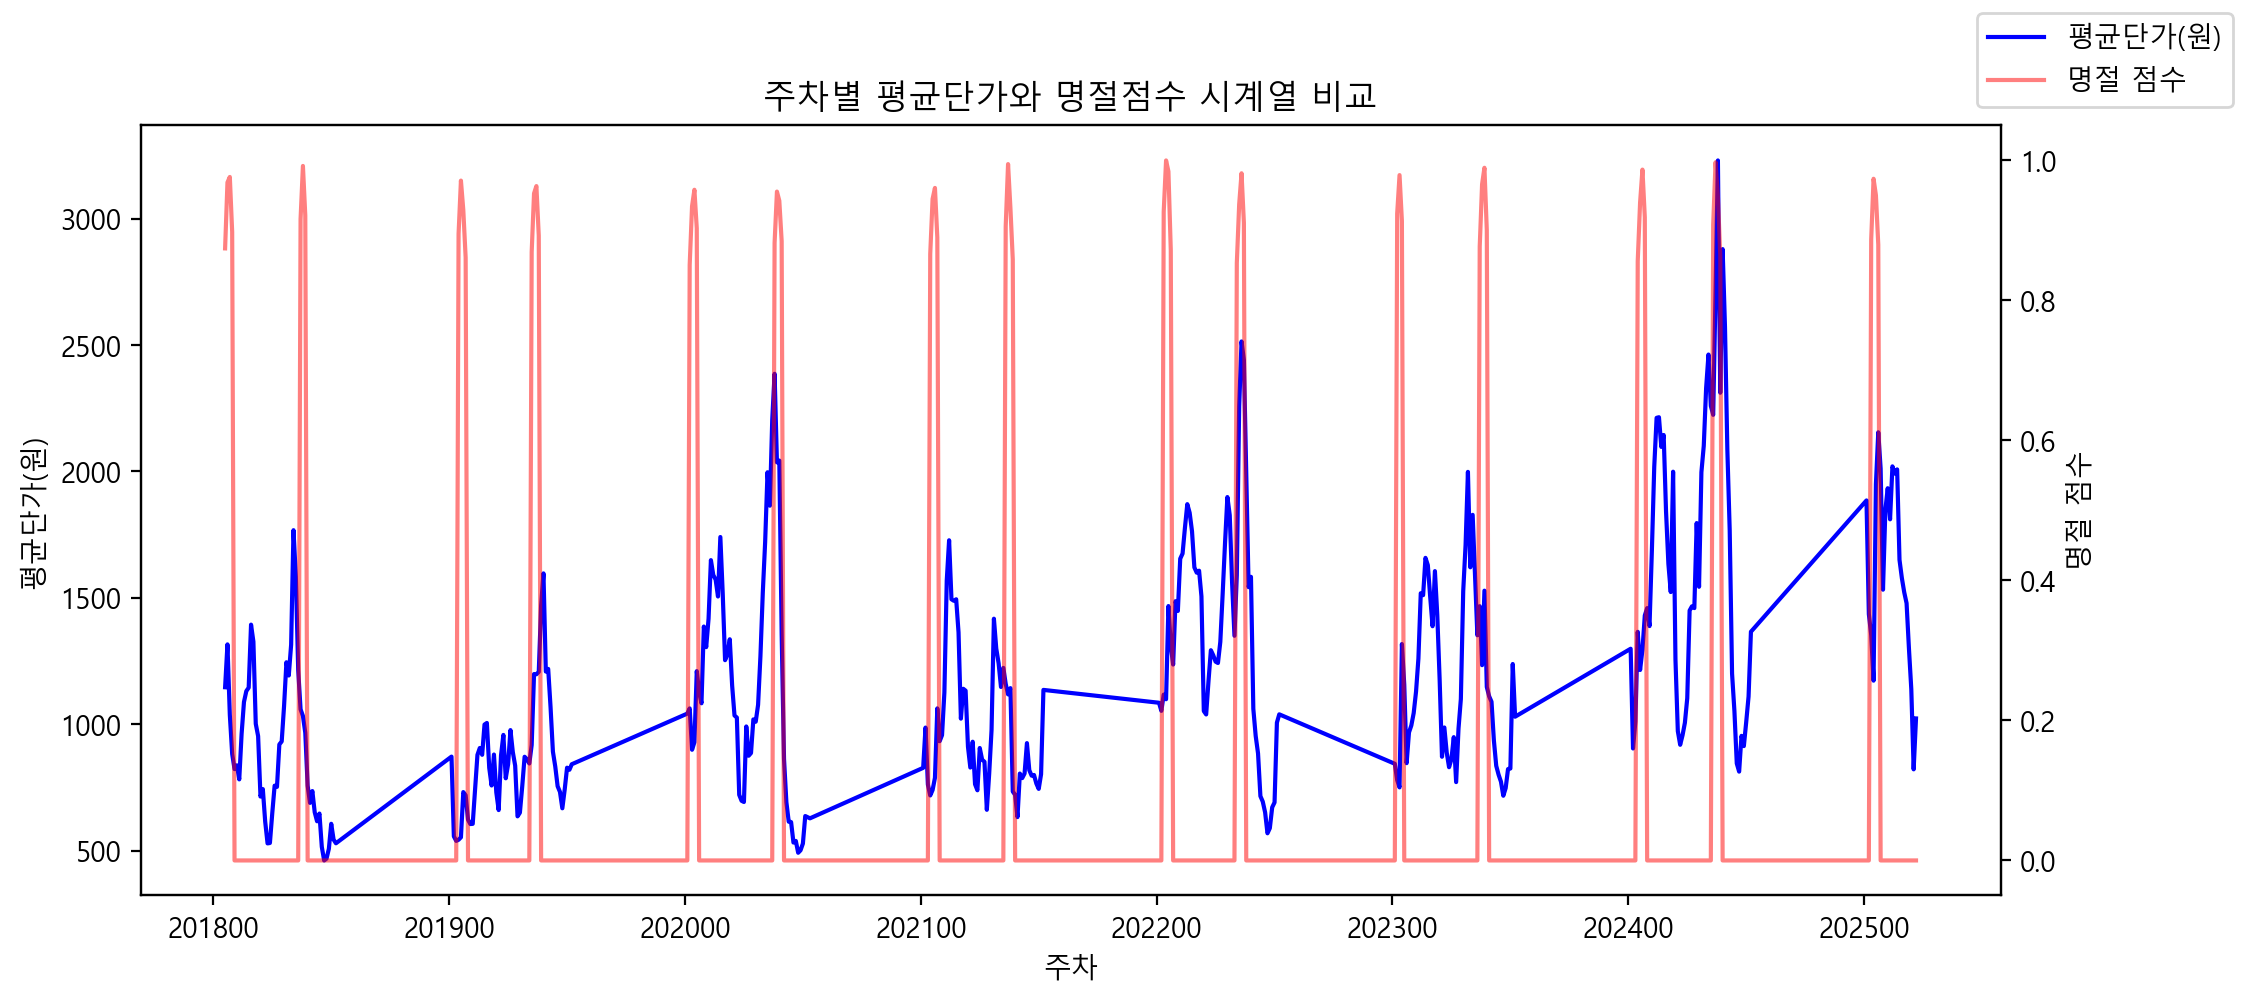

In [51]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df['weekno'], df['평균단가(원)'], label='평균단가(원)', color='blue')
ax2 = ax1.twinx()
ax2.plot(df['weekno'], df['holiday_score'], label='명절 점수', color='red', alpha=0.5)

ax1.set_xlabel('주차')
ax1.set_ylabel('평균단가(원)')
ax2.set_ylabel('명절 점수')
plt.title("주차별 평균단가와 명절점수 시계열 비교")
fig.legend(loc='upper right')
plt.show()

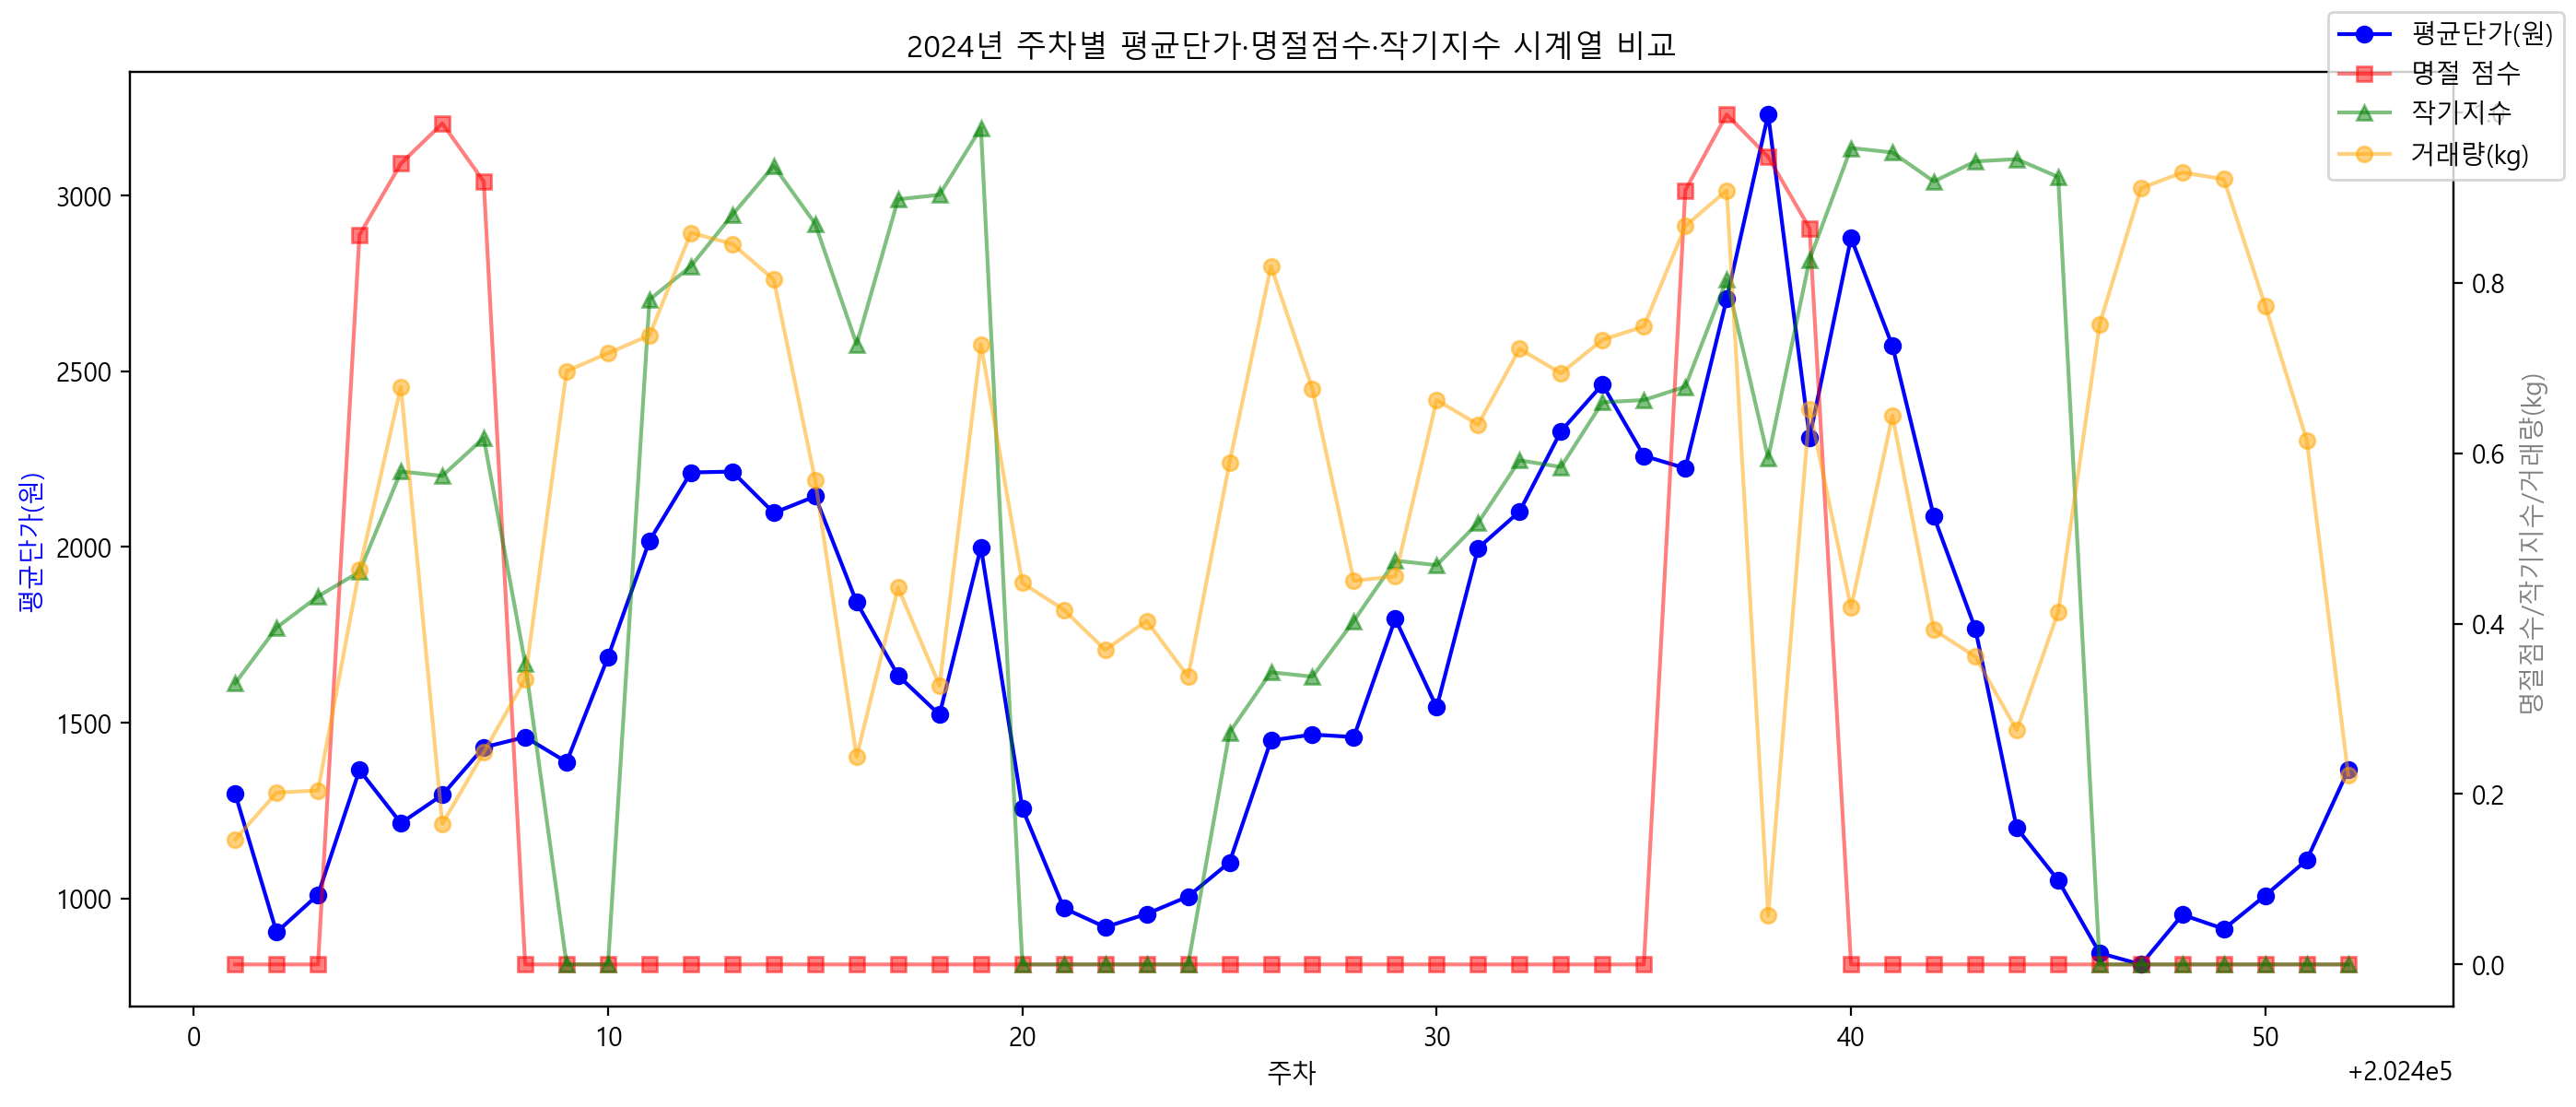

In [54]:
# 1. 2024년도 데이터만 추출
df_24 = df_scaled[df_scaled['weekno'].astype(str).str[:4] == '2024']

# 2. 시계열 그래프 (평균단가, 명절점수, 작기지수)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,6))

# 평균단가(원) - 파란선
ax1.plot(df_24['weekno'], df_24['평균단가(원)'], color='blue', marker='o', label='평균단가(원)')
ax1.set_xlabel('주차')
ax1.set_ylabel('평균단가(원)', color='blue')

# holiday_score, grow_score는 보조축(twinx)
ax2 = ax1.twinx()
ax2.plot(df_24['weekno'], df_24['holiday_score'], color='red', marker='s', alpha=0.5, label='명절 점수')
ax2.plot(df_24['weekno'], df_24['grow_score'], color='green', marker='^', alpha=0.5, label='작기지수')
ax2.plot(df_24['weekno'], df_24['총거래량(kg)'], color='orange', marker='o', alpha=0.5, label='거래량(kg)')
ax2.set_ylabel('명절점수/작기지수/거래량(kg)', color='gray')

# 범례 & 기타
fig.legend(loc='upper right')
plt.title("2024년 주차별 평균단가·명절점수·작기지수 시계열 비교")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

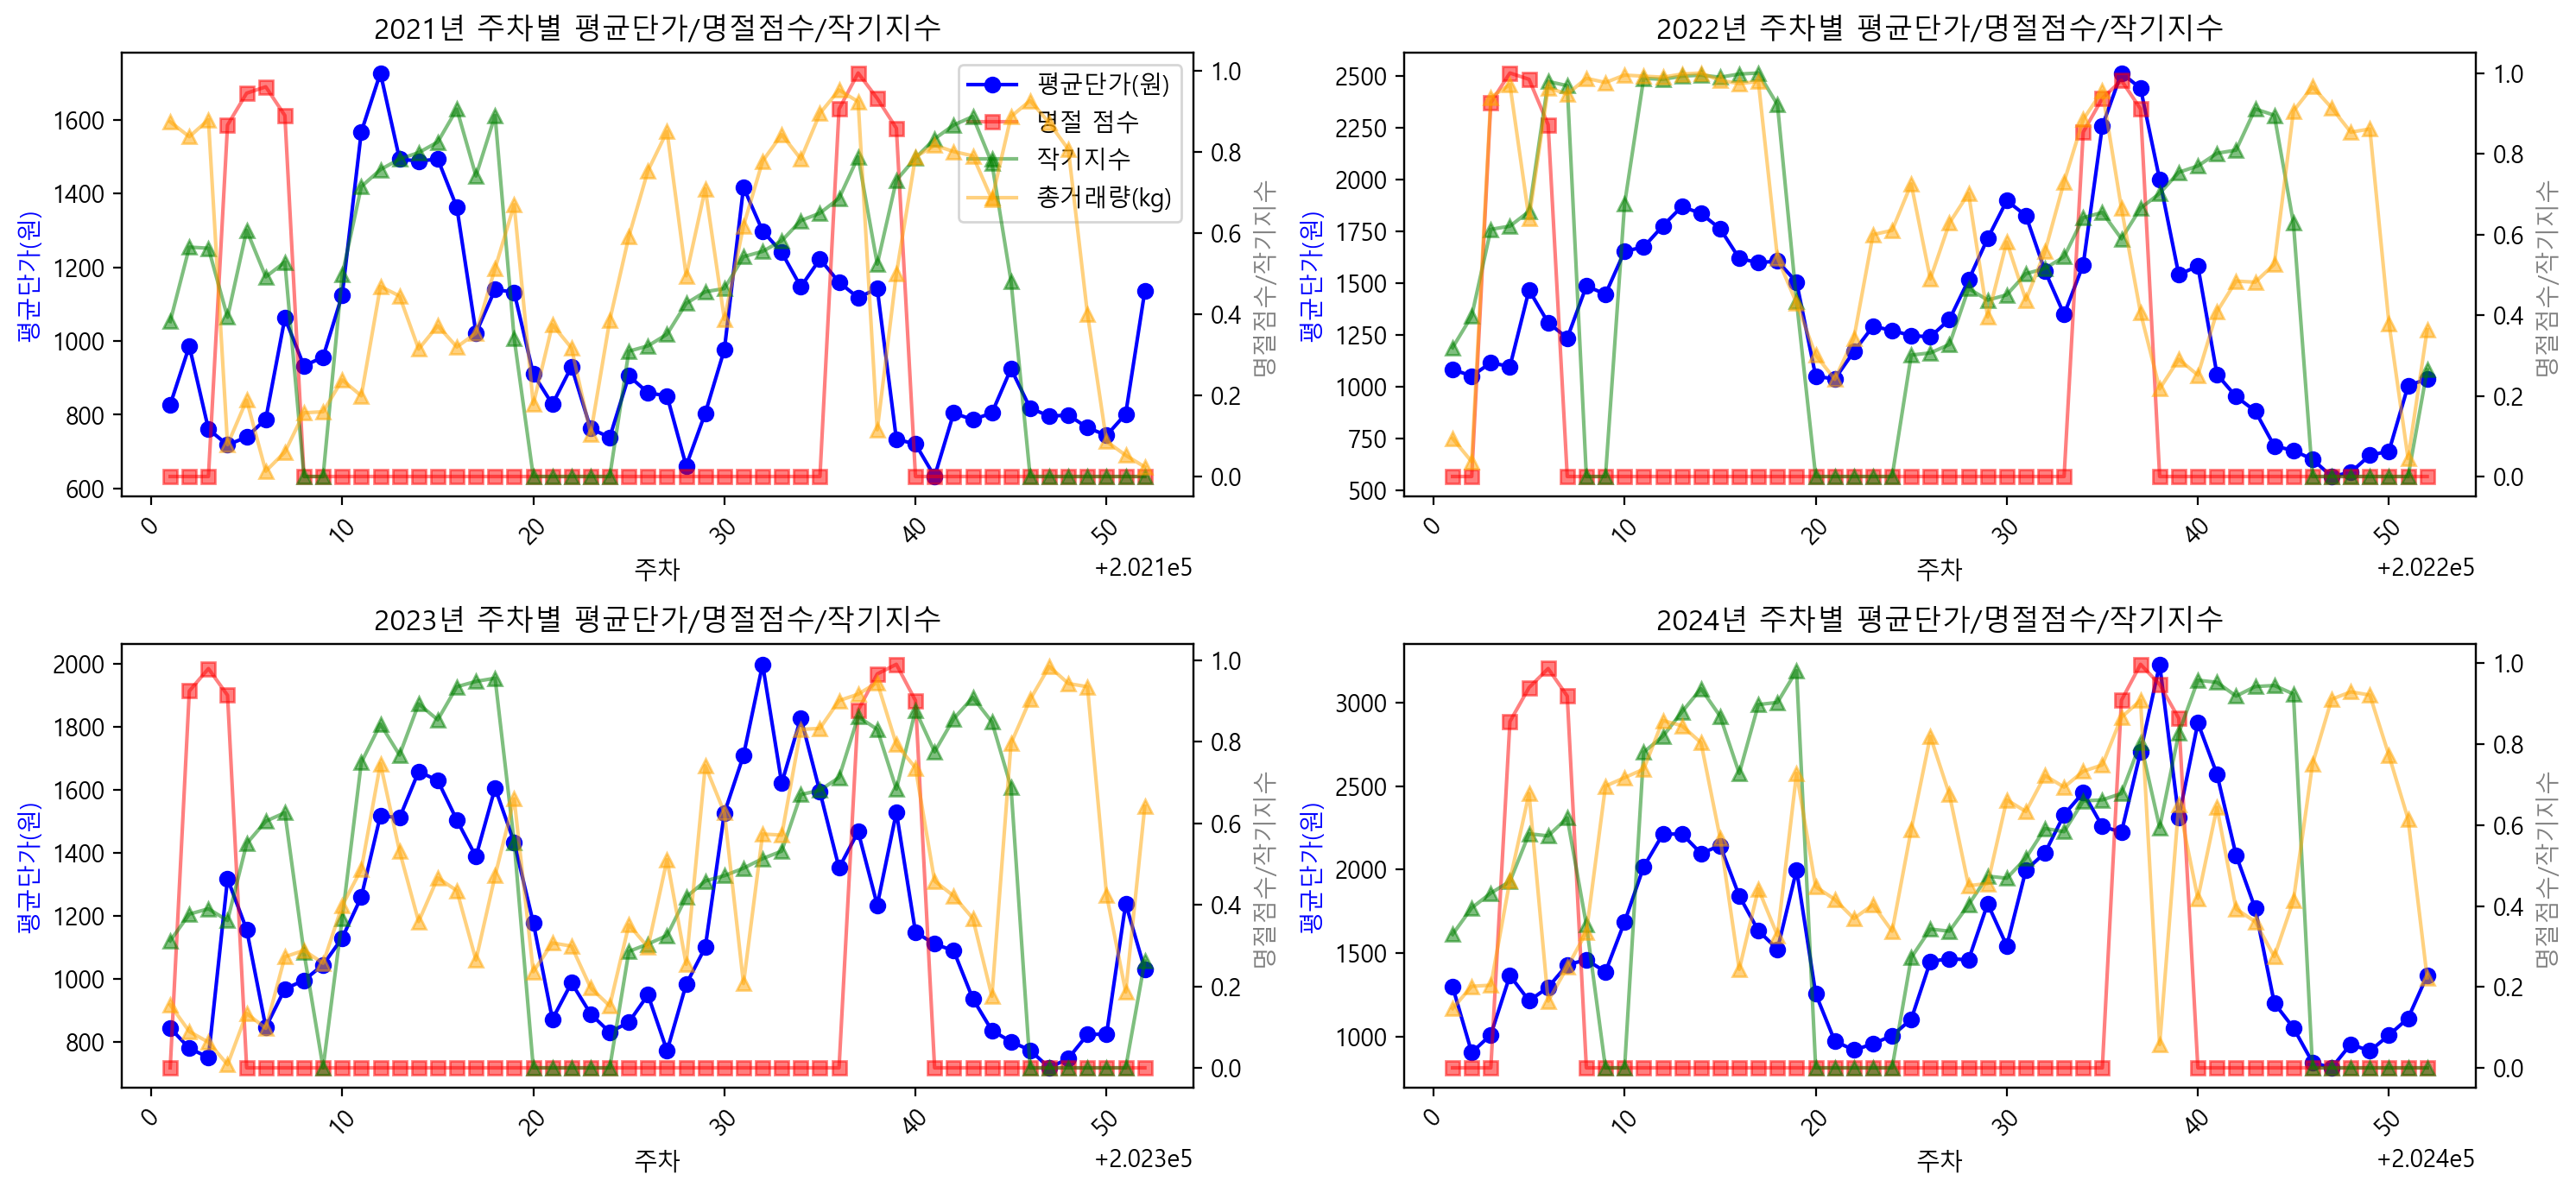

In [58]:
import matplotlib.pyplot as plt

years = [2021, 2022, 2023, 2024]
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharey=False)
axes = axes.flatten()

for i, year in enumerate(years):
    # 연도별 데이터 추출
    df_y = df_scaled[df_scaled['weekno'].astype(str).str[:4] == str(year)]
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # 평균단가(원) - 파란선
    ax1.plot(df_y['weekno'], df_y['평균단가(원)'], color='blue', marker='o', label='평균단가(원)')
    ax1.set_xlabel('주차')
    ax1.set_ylabel('평균단가(원)', color='blue')
    ax1.tick_params(axis='x', rotation=45)
    
    # 명절점수(빨간선)
    ax2.plot(df_y['weekno'], df_y['holiday_score'], color='red', marker='s', alpha=0.5, label='명절 점수')
    # 작기지수(초록선)
    ax2.plot(df_y['weekno'], df_y['grow_score'], color='green', marker='^', alpha=0.5, label='작기지수')
    ax2.plot(df_y['weekno'], df_y['총거래량(kg)'], color='orange', marker='^', alpha=0.5, label='총거래량(kg)')
    ax2.set_ylabel('명절점수/작기지수', color='gray')
    
    ax1.set_title(f"{year}년 주차별 평균단가/명절점수/작기지수")
    if i == 0:  # 첫 번째 그래프에만 범례 표시(위/오른쪽)
        lines, labels = [], []
        for ax in [ax1, ax2]:
            line, label = ax.get_legend_handles_labels()
            lines += line
            labels += label
        ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


,weekno,일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),평균단가(원)
0,201805,0.033359,0.048344,0.030628,0.101001,0.093199,0.000000,1612.693431
1,201806,0.018284,0.107545,0.012796,0.102192,0.132648,0.000000,1662.692771
2,201807,0.043912,0.105839,0.049213,0.329671,0.471734,0.000000,1545.601399
3,201808,0.145758,0.135302,0.130347,0.161134,0.231455,0.000000,1345.739130
4,201809,0.189920,0.202581,0.157942,0.239185,0.563037,0.000000,1239.349593
...,...,...,...,...,...,...,...,...
378,202518,0.480470,0.539896,0.447065,0.216493,0.459492,0.474180,2869.189655
379,202519,0.495368,0.498683,0.472715,0.427818,0.408548,0.408457,2503.663158
380,202520,0.588934,0.606074,0.534571,0.468000,0.533855,0.550122,2612.384000
381,202521,0.637684,0.660160,0.585514,0.489391,0.212447,0.246403,2595.344000


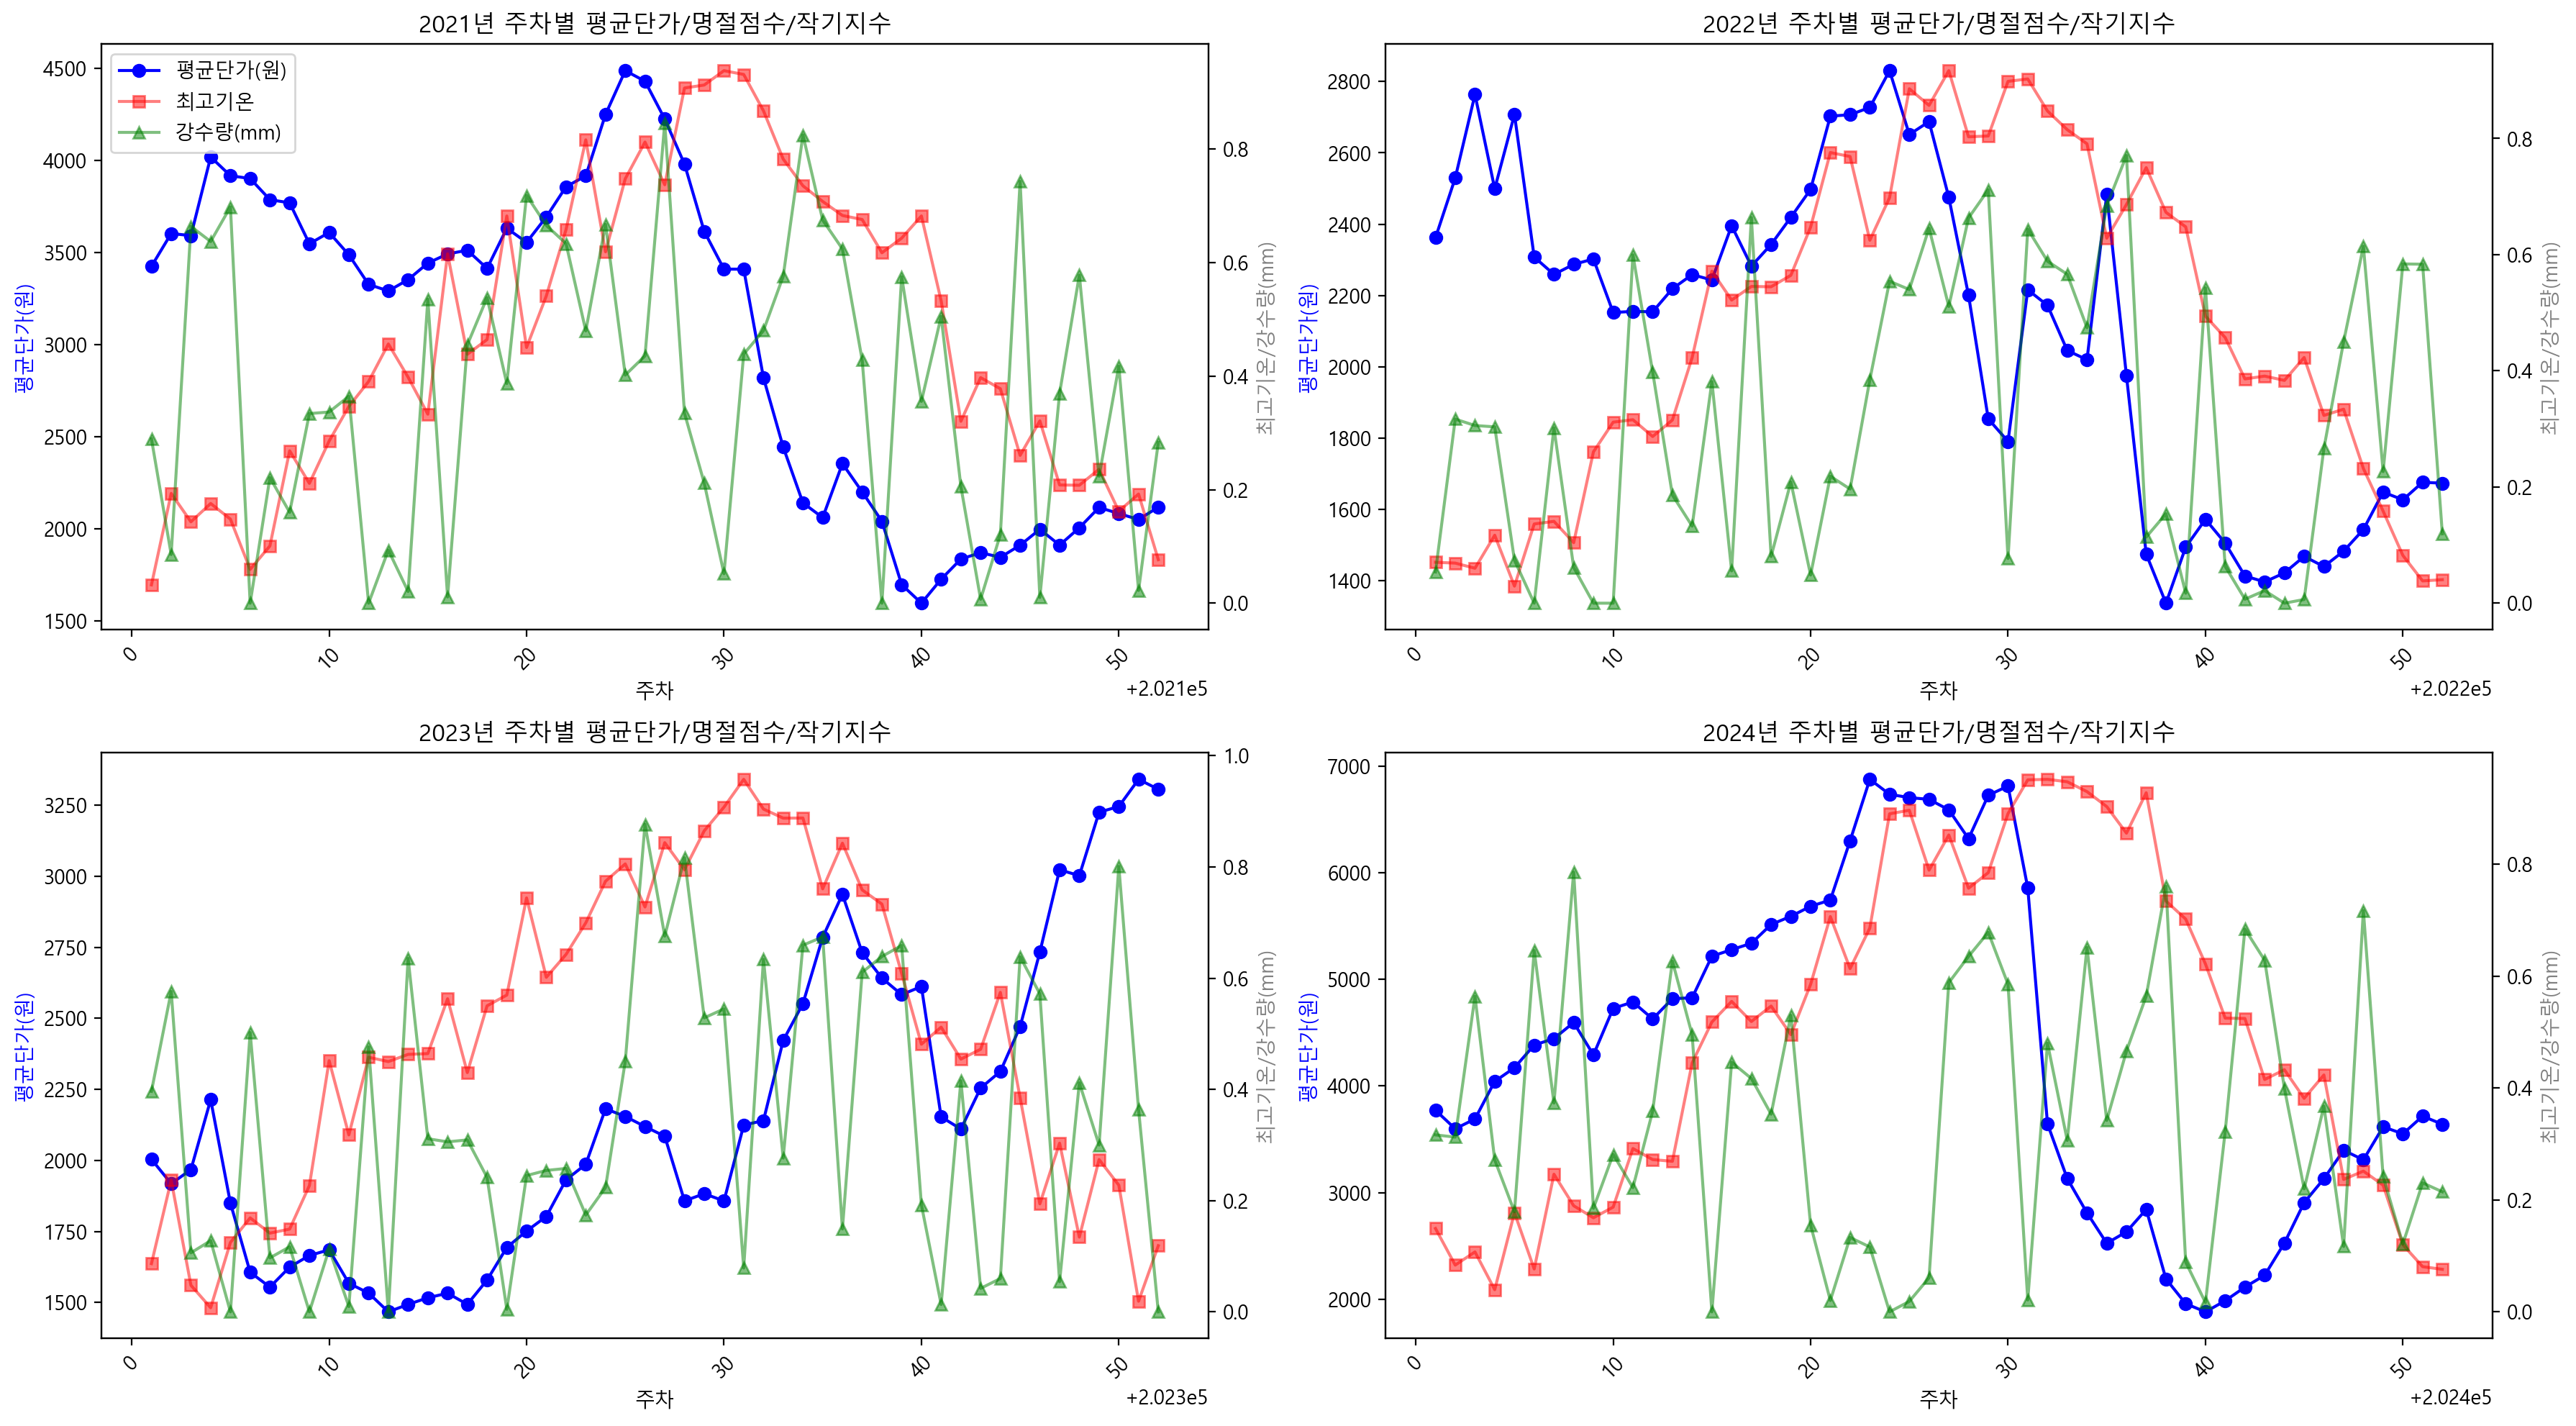

In [184]:
import matplotlib.pyplot as plt

years = [2021, 2022, 2023, 2024]
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=False)
axes = axes.flatten()

for i, year in enumerate(years):
    # 연도별 데이터 추출
    df_y = df_group3[df_group3['weekno'].astype(str).str[:4] == str(year)]
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # 평균단가(원) - 파란선
    ax1.plot(df_y['weekno'], df_y['평균단가(원)'], color='blue', marker='o', label='평균단가(원)')
    ax1.set_xlabel('주차')
    ax1.set_ylabel('평균단가(원)', color='blue')
    ax1.tick_params(axis='x', rotation=45)
    
    # 명절점수(빨간선)
    ax2.plot(df_y['weekno'], df_y['최고기온'], color='red', marker='s', alpha=0.5, label='최고기온')
    # 작기지수(초록선)
    ax2.plot(df_y['weekno'], df_y['강수량(mm)'], color='green', marker='^', alpha=0.5, label='강수량(mm)')
    ax2.set_ylabel('최고기온/강수량(mm)', color='gray')
    
    ax1.set_title(f"{year}년 주차별 평균단가/명절점수/작기지수")
    if i == 0:  # 첫 번째 그래프에만 범례 표시(위/오른쪽)
        lines, labels = [], []
        for ax in [ax1, ax2]:
            line, label = ax.get_legend_handles_labels()
            lines += line
            labels += label
        ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()


In [189]:
df_scaled

,year,품종코드,등급코드,직팜산지코드,총거래량(kg),일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),...,최고기온_t-4,최저기온_t-4,평균상대습도_t-4,강수량(mm)_t-4,1시간최고강수량(mm)_t-4,item_code,weekno,holiday_flag,holiday_score,grow_score
0,2018,1,11,1000,0.995430,0.020048,0.032533,0.016517,0.071541,0.646647,...,0.016016,0.081582,0.044133,0.000000,0.000000,0.0,201805,0.412412,0.820821,0.250250
1,2018,1,11,1008,0.900836,0.024241,0.027027,0.029029,0.090886,0.000000,...,0.023846,0.014014,0.106357,0.000000,0.000000,0.0,201805,0.412412,0.820821,0.250250
2,2018,1,11,1019,0.974267,0.032494,0.041041,0.015667,0.085409,0.000000,...,0.033446,0.028028,0.154154,0.000000,0.000000,0.0,201805,0.412412,0.820821,0.250250
3,2018,1,11,1026,0.999254,0.018441,0.031532,0.002668,0.134251,0.000000,...,0.025025,0.062062,0.205755,0.000000,0.000000,0.0,201805,0.412412,0.820821,0.250250
4,2018,1,11,1027,0.998511,0.017000,0.031532,0.002668,0.140859,0.000000,...,0.025025,0.062062,0.216957,0.000000,0.000000,0.0,201805,0.412412,0.820821,0.250250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77423,2025,100,13,1085,0.256256,0.710210,0.782783,0.637638,0.108108,0.000000,...,0.657157,0.459960,0.138652,0.958749,0.971757,0.0,202522,0.412412,0.000000,0.509009
77424,2025,100,12,1159,0.118118,0.623123,0.590090,0.649149,0.257257,0.000000,...,0.719219,0.487487,0.048048,0.752419,0.801802,0.0,202522,0.412412,0.000000,0.509009
77425,2025,100,13,1159,0.248248,0.623123,0.590090,0.649149,0.257257,0.000000,...,0.616116,0.531031,0.060060,0.000000,0.000000,0.0,202522,0.412412,0.000000,0.509009
77426,2025,100,11,1001,0.014515,0.607608,0.692192,0.568569,0.151151,0.000000,...,0.101101,0.155656,0.770270,0.000000,0.000000,0.0,202522,0.412412,0.000000,0.509009


In [201]:
df_explain2 = df_scaled[['weekno','일평균기온', '최고기온','최저기온', '평균상대습도', '강수량(mm)', '1시간최고강수량(mm)', 'holiday_score', 'grow_score', '총거래량(kg)', '평균단가(원)']]
df_group4 = df_explain2.groupby(['weekno']).agg({
    '일평균기온':'mean', '최고기온':'mean','최저기온':'mean', '평균상대습도':'mean', '강수량(mm)':'mean', '1시간최고강수량(mm)':'mean', 
    'holiday_score':'mean', 'grow_score':'mean', '총거래량(kg)':'mean', '평균단가(원)':'mean'
}).reset_index()
df_group4

,weekno,일평균기온,최고기온,최저기온,평균상대습도,강수량(mm),1시간최고강수량(mm),holiday_score,grow_score,총거래량(kg),평균단가(원)
0,201805,0.033359,0.048344,0.030628,0.101001,0.093199,0.000000,0.820821,0.250250,0.812993,1612.693431
1,201806,0.018284,0.107545,0.012796,0.102192,0.132648,0.000000,0.914915,0.268268,0.833748,1662.692771
2,201807,0.043912,0.105839,0.049213,0.329671,0.471734,0.000000,0.978979,0.268268,0.696626,1545.601399
3,201808,0.145758,0.135302,0.130347,0.161134,0.231455,0.000000,0.848348,0.293293,0.518496,1345.739130
4,201809,0.189920,0.202581,0.157942,0.239185,0.563037,0.000000,0.000000,0.310310,0.536922,1239.349593
...,...,...,...,...,...,...,...,...,...,...,...
378,202518,0.480470,0.539896,0.447065,0.216493,0.459492,0.474180,0.000000,0.432933,0.500528,2869.189655
379,202519,0.495368,0.498683,0.472715,0.427818,0.408548,0.408457,0.000000,0.432933,0.443180,2503.663158
380,202520,0.588934,0.606074,0.534571,0.468000,0.533855,0.550122,0.000000,0.432933,0.474168,2612.384000
381,202521,0.637684,0.660160,0.585514,0.489391,0.212447,0.246403,0.000000,0.493994,0.493818,2595.344000


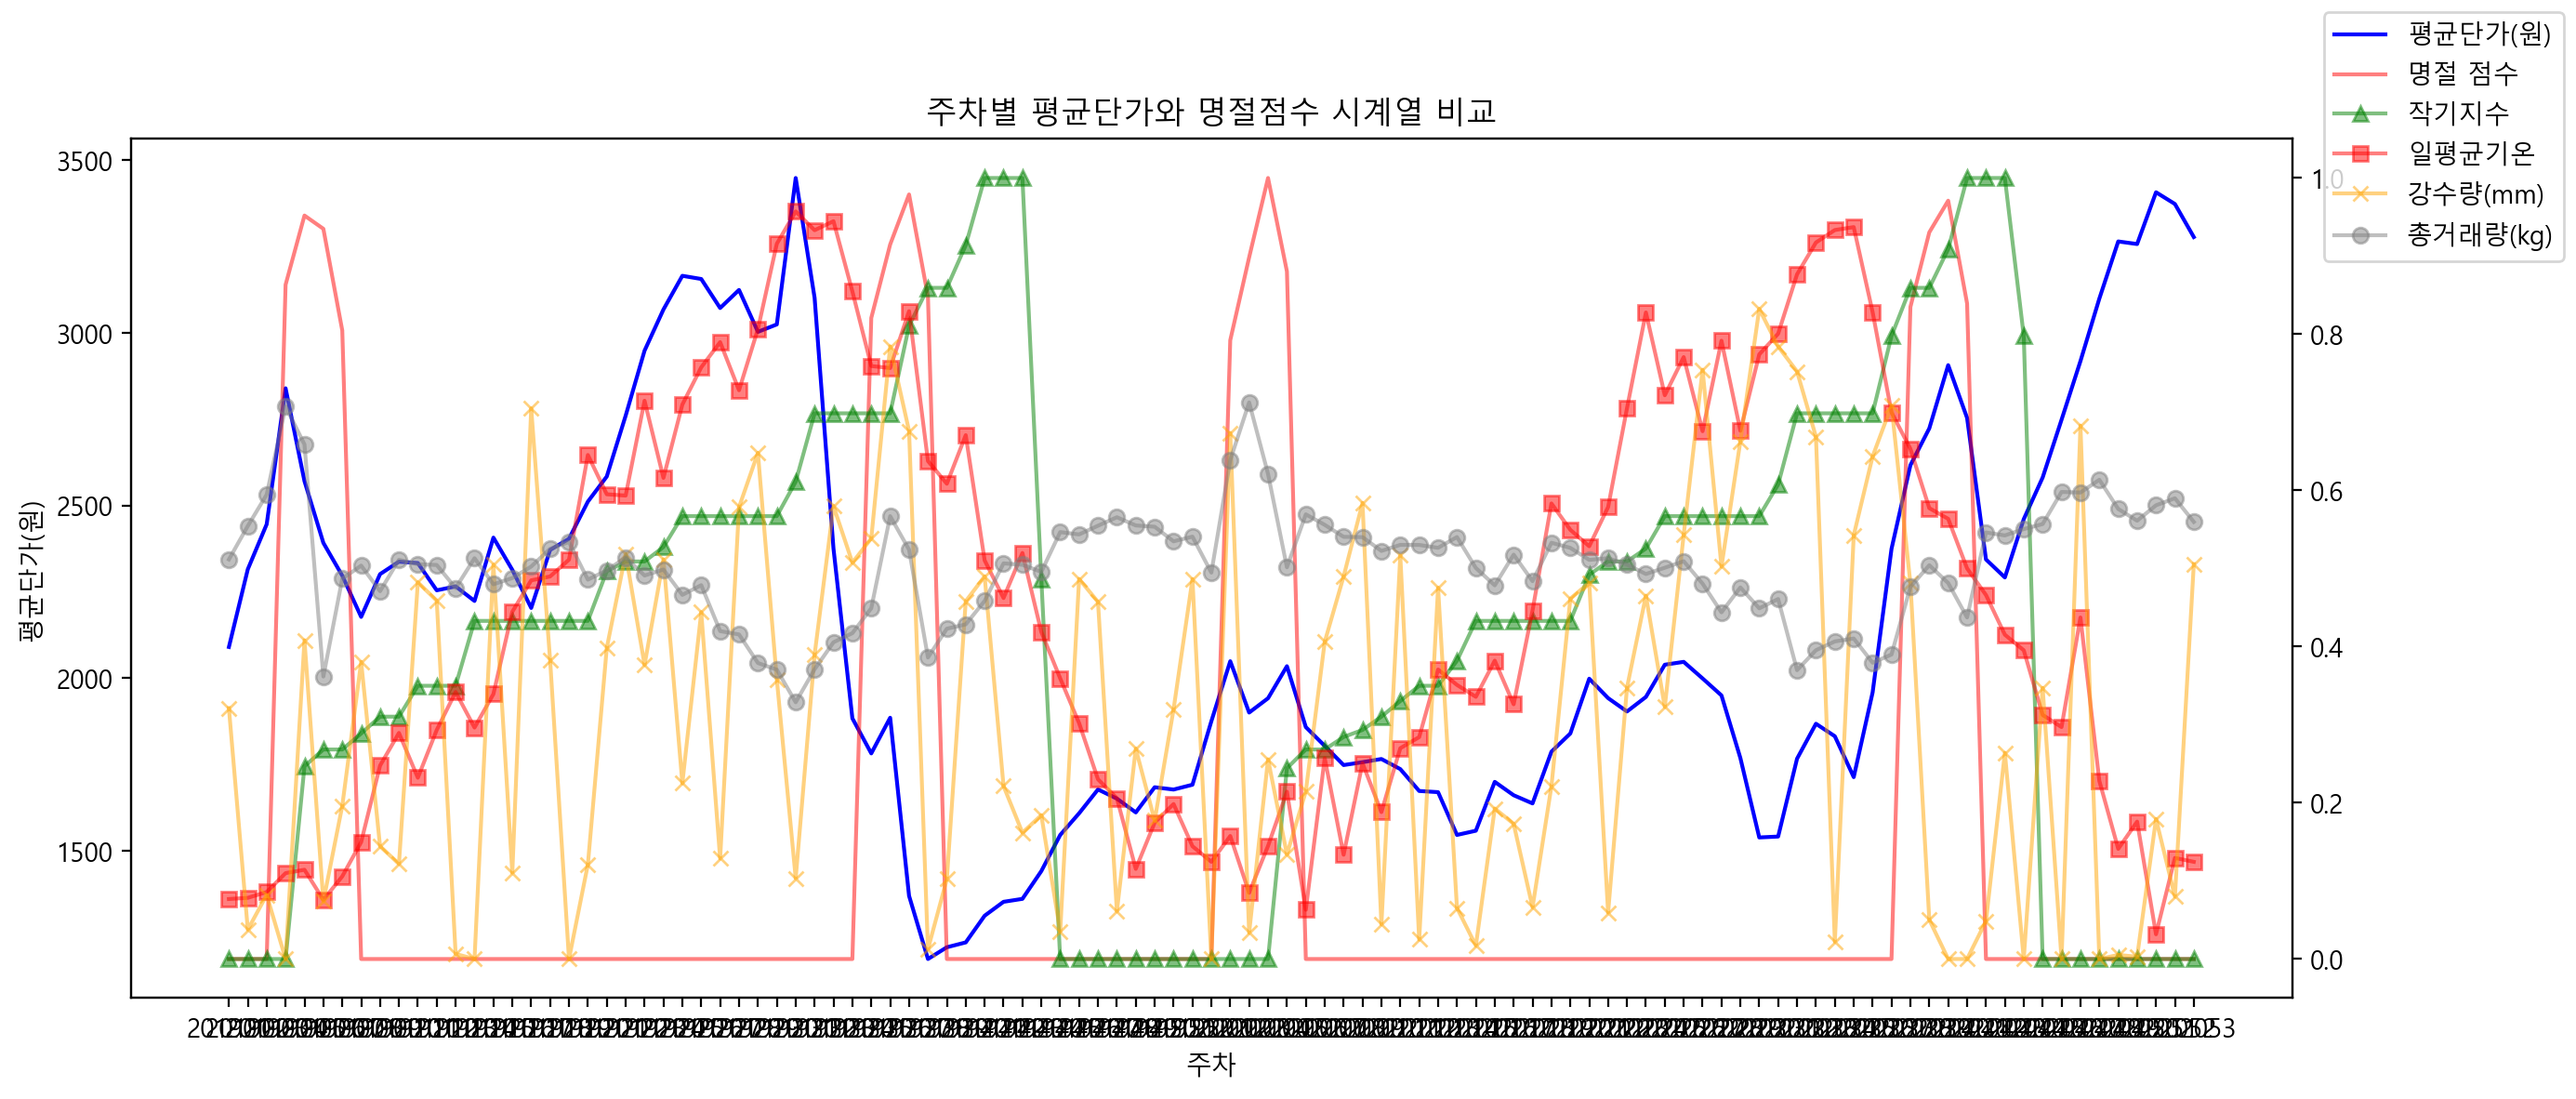

In [210]:

df_y1 = df_group4[df_group4['weekno'].astype(str).str[:4] == str('2019')]
df_y2 = df_group4[df_group4['weekno'].astype(str).str[:4] == str('2020')]
df_y = pd.concat([df_y1, df_y2])
df_y['weekno'] = df_y['weekno'].astype(str)

fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(df_y['weekno'], df_y['평균단가(원)'], label='평균단가(원)', color='blue')
ax2 = ax1.twinx()
ax2.plot(df_y['weekno'], df_y['holiday_score'], label='명절 점수', color='red', alpha=0.5)
ax2.plot(df_y['weekno'], df_y['grow_score'], color='green', marker='^', alpha=0.5, label='작기지수')
ax2.plot(df_y['weekno'], df_y['일평균기온'], color='red', marker='s', alpha=0.5, label='일평균기온')
ax2.plot(df_y['weekno'], df_y['강수량(mm)'], color='orange', marker='x', alpha=0.5, label='강수량(mm)')
ax2.plot(df_y['weekno'], df_y['총거래량(kg)'], color='gray', marker='o', alpha=0.5, label='총거래량(kg)')

ax1.set_xlabel('주차')
ax1.set_ylabel('평균단가(원)')
plt.title("주차별 평균단가와 명절점수 시계열 비교")
fig.legend(loc='upper right')
plt.show()